# Clahe

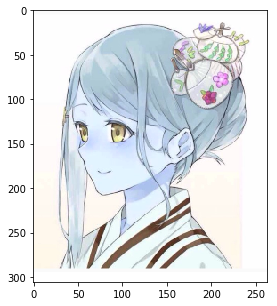

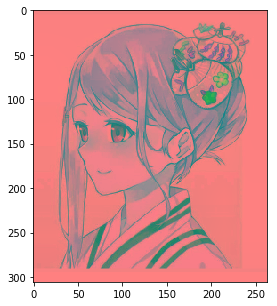

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from six import BytesIO
from PIL import Image

img = cv2.imread('img/t.png',3)
bk_img = img.copy()
fig = plt.figure(figsize=(5, 5))
plt.imshow(img)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
cl = clahe.apply(l)
limg = cv2.merge((cl, a, b))
fig = plt.figure(figsize=(5, 5))
plt.imshow(limg)


# Gray

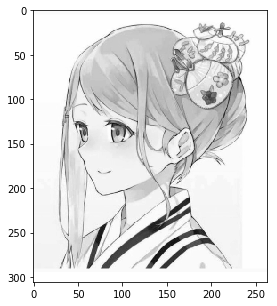

In [2]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig = plt.figure(figsize=(5, 5))
plt.imshow(img_gray,cmap='gray')
plt.show()

# brisk algo

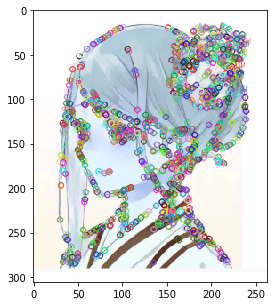

In [3]:
brisk = cv2.BRISK_create()
kp = brisk.detect(img, None)
kp, des = brisk.compute(img, kp)
out_img = img.copy()
out_img = cv2.drawKeypoints(img, kp, out_img)
fig = plt.figure(figsize=(5, 5))
plt.imshow(out_img)

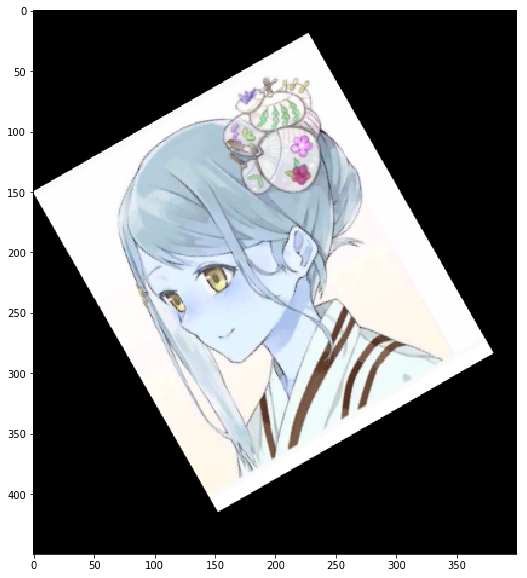

In [4]:
ang=np.pi/6
rot_mat = np.array([[np.cos(ang), np.sin(ang), 0], [-np.sin(ang), np.cos(ang), 150]])
img_30 = cv2.warpAffine(img, rot_mat, (400,450))
plt.figure(figsize=(10, 10))
plt.imshow(img_30)

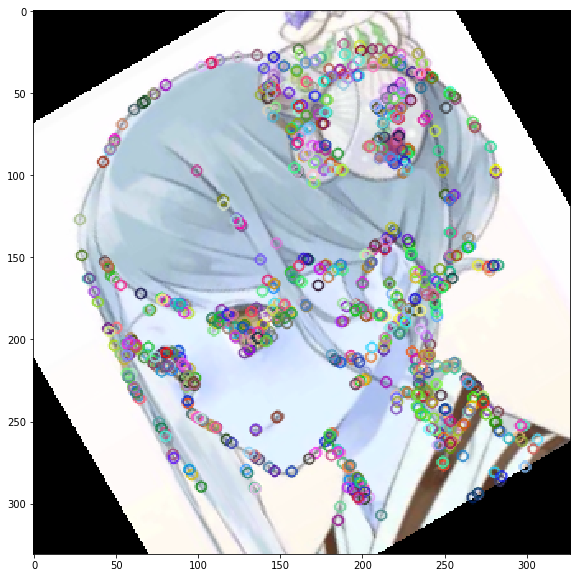

In [5]:
img_30 =  cv2.imread('img/t30.png',3)
(kp_30, des_30) = brisk.detectAndCompute(img_30, None)
bk30_img = img_30.copy()
out_img = img_30.copy()
out_img = cv2.drawKeypoints(bk30_img, kp_30, out_img)
plt.figure(figsize=(10, 10))
plt.imshow(out_img)


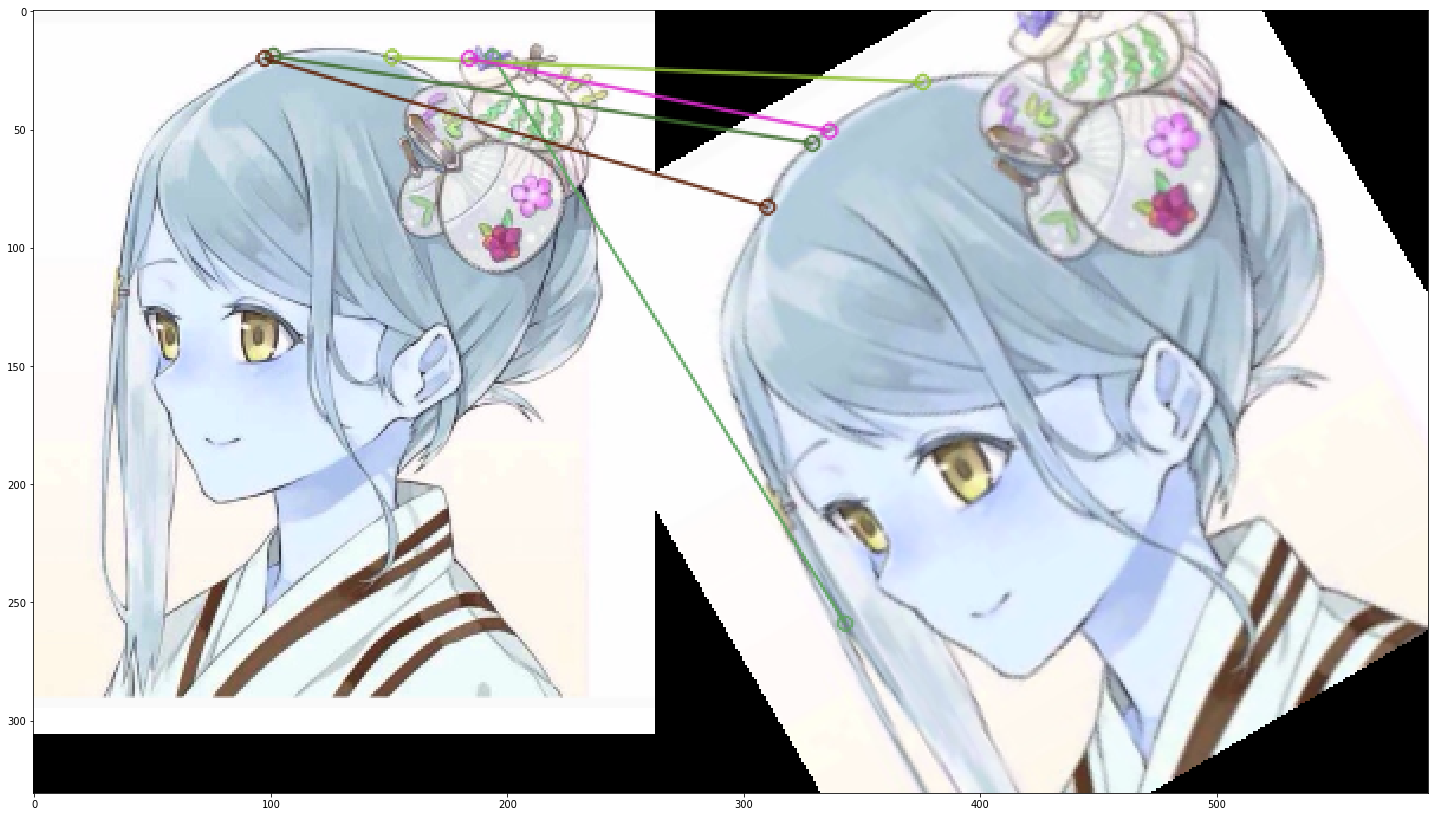

In [6]:
matcher = cv2.BFMatcher()
matches = matcher.match(des, des_30)
out_img = cv2.drawMatches(img, kp, bk30_img, kp_30, matches[0:5], out_img,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(25, 15))
plt.imshow(out_img)

# KNN match

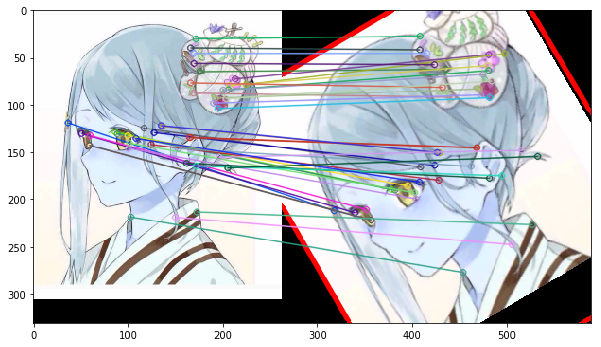

In [7]:

FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,
                                 table_number=6,
                                 key_size=12,
                                 multi_probe_level=1)
search_params = dict(checks=100)
flann = cv2.FlannBasedMatcher(index_params, search_params)
knn_matches = flann.knnMatch(des, des_30, k=2)

good_matches = []
lowe_ratio_test = 0.3
min_match_count = 1

for m, n in knn_matches:
    if m.distance < n.distance * lowe_ratio_test:
        good_matches.append(m)

    if len(good_matches) > min_match_count:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_30[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    else:
        src_pts = None
        dst_pts = None
M, mask = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=4.0)
matches_mask = mask.ravel().tolist()

        # Apply homography matrix.
h, w, c = img.shape
# ref image
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
# test image
dst = cv2.perspectiveTransform(pts, M)

test_img = cv2.polylines(img=img_30, pts=[np.int32(dst)], isClosed=True,
                                 color=255, thickness=3, lineType=cv2.LINE_AA)

img_matches = np.empty(
            shape=(max(img.shape[0], img_30.shape[0]),
                   img.shape[1] + img_30.shape[1],
                   3),
            dtype=np.uint8)
out_img = cv2.drawMatches(img, kp,
                        test_img, kp_30,
                        matches1to2=good_matches,
                        outImg=img_matches,
                        matchesMask=matches_mask,
                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 10))
plt.imshow(out_img)

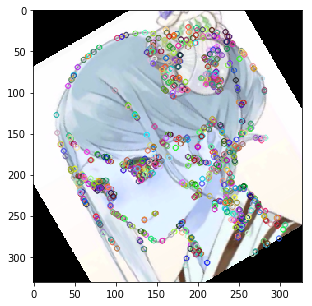

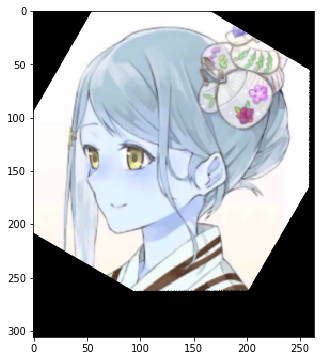

In [8]:
im30 =  cv2.imread('img/t30.png',3)
(kp_i30, des_i30) = brisk.detectAndCompute(im30, None)
bk30_img = im30.copy()
o30_img = im30.copy()
o30_img = cv2.drawKeypoints(bk30_img, kp_i30, o30_img)
plt.figure(figsize=(10, 5))
plt.imshow(o30_img)


# test image
points = np.int32(dst).reshape(4, 2)
rect = np.zeros((4, 2), dtype="float32")
rect[0], rect[1], rect[2], rect[3] = points[0], points[3], points[2], points[1]
# ref image
destination = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype="float32")
# homography matrix
h_mat = cv2.getPerspectiveTransform(rect, destination)
frame_wrap = cv2.warpPerspective(src=im30, M=h_mat, dsize=(w, h))
# test image overlay
frame_overlay = frame_wrap.copy()

plt.figure(figsize=(15, 6))
plt.imshow(frame_overlay)